In [39]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle
import scipy.stats as stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Yahoo Data (5 minute interval)

In [40]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '30m')
stocks.transform_data()
# Write to transformed data to SQL
#stocks.insert_SQL()
# Read from SQL
#stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [41]:
stocks.raw_data.shape

(65, 126)

In [42]:
stocks.transformed_data.to_csv('data/mydata.csv')

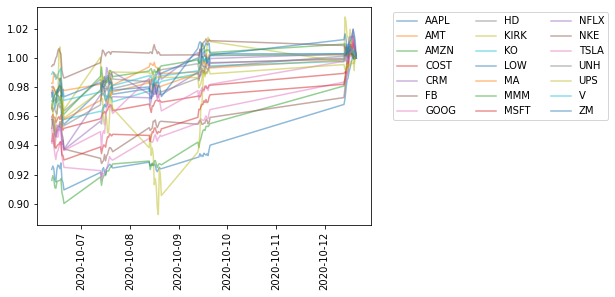

In [43]:
stocks.plot_raw(scale = -1)

# Model

In [44]:
stocks.transformed_data

,symbol,price
Datetime,,
2020-10-12 15:30:00-04:00,AAPL,124.419998
2020-10-08 14:00:00-04:00,AAPL,114.900101
2020-10-08 14:30:00-04:00,AAPL,115.099998
2020-10-08 15:00:00-04:00,AAPL,114.964996
2020-10-08 15:30:00-04:00,AAPL,114.970001
...,...,...
2020-10-08 14:30:00-04:00,ZM,482.429993
2020-10-08 14:00:00-04:00,ZM,481.739990
2020-10-08 13:30:00-04:00,ZM,481.089996


In [45]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'Datetime')['price']
# Note if pulling from SQL index = 'DateTime'
# Normalize by Last Value
data = data/data.iloc[-1]
data.index = pd.DatetimeIndex(data.index).to_period('M')

/home/erichullander/anaconda3/envs/StockPrice/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


# Out of Sample Validation (MASE)

https://robjhyndman.com/papers/forecast-accuracy.pdf
page 7. 

Using All data for each Q

In [46]:
def get_MASE(data,lags):
    # Calculate Q for each series. MAE of naive forecast for each series
    Q = np.abs(data.diff().dropna()).mean()
    # Calculate MASE for each series as 
    MASE = []
    MASEN = []
    n_ahead = 1
    # rolling origin point forecasts.
    # has to train on at least n = lags samples
    for n in range(lags,(data.shape[0] - 1)):
        try:
            M = YahooStocks.Model(data=data.iloc[0:n])
            M.fitVAR(lags)
            M.forecast(n_ahead)
            MAEnaive = np.abs(M.data.diff()).dropna().iloc[-1].values
            MAE = np.abs((data.iloc[n].values - M.fcast.values))[0]
            MASE.append(MAE/Q)
            MASEN.append(MAEnaive/Q)
        except:
            continue
    return MASE, MASEN

In [47]:
data.shape

(65, 21)

In [48]:
lags = 50
MASE, MASEN = get_MASE(data, 50)

# Significance Testing

In [49]:
# Across All Stocks, how does VAR compare to Naive?
# Not much different
A = pd.DataFrame(MASE).melt()['value']
B = pd.DataFrame(MASEN).melt()['value']
print(np.mean(A))
print(np.mean(B))
stats.ttest_rel(A, B)

1.003737691223694
1.111358467675828


Ttest_relResult(statistic=-1.262105900041002, pvalue=0.20818898935262842)

In [50]:
#just to remind myself...
#stats.ttest_1samp(A - B, 0)
stats.ttest_ind(pd.DataFrame(MASE)['AAPL'], pd.DataFrame(MASEN)['AAPL'])

Ttest_indResult(statistic=-0.9611328177120676, pvalue=0.34796236996248786)

In [51]:
# pairwise ttest between naive and var. Nobody looks significant, e.g. aapl naive to aapl var for all stocks
F, p = stats.f_oneway(np.array(MASE), np.array(MASEN), axis = 0)
p

array([0.34796237, 0.39380721, 0.45988321, 0.783063  , 0.73487301,
       0.79699063, 0.45718733, 0.84608324, 0.83493562, 0.92034112,
       0.6152528 , 0.81331565, 0.98552561, 0.61520816, 0.60318693,
       0.84558924, 0.42484153, 0.55967651, 0.91576239, 0.43426155,
       0.69450784])

In [52]:
A = pd.DataFrame(MASE).mean().values
B = pd.DataFrame(MASEN).mean().values

In [53]:
stats.ttest_ind(A, B)

Ttest_indResult(statistic=-0.9328532108639608, pvalue=0.35649276806691377)

In [54]:
F, p = stats.f_oneway(A, B, axis = 0)
p

0.35649276806691454

In [55]:
# Are there any stocks that are more predictable than others? Not really.
stats.f_oneway(*np.array(pd.DataFrame(MASE) - pd.DataFrame(MASEN)).T, axis = 0)

F_onewayResult(statistic=0.34410511309862307, pvalue=0.9964879191390494)

-0.1076207764521339


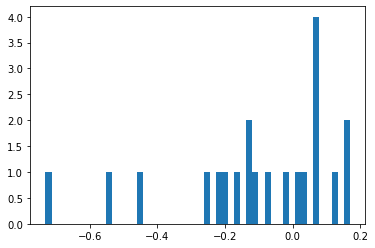

In [56]:
plt.hist(A - B, bins = 50)
print(np.mean(A - B))
plt.show()

# Forecast

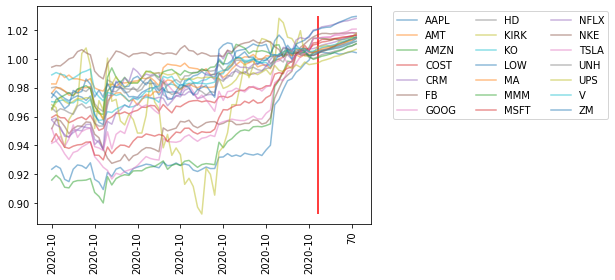

In [64]:
M = YahooStocks.Model(data=data.iloc[0:-3])
M.fitVAR(lags)
M.forecast(10)
M.plot_fcast()

In [65]:
M.fcast.iloc[0].sort_values(ascending = False)

symbol
NFLX    1.020513
ZM      1.020254
FB      1.016566
TSLA    1.014336
AMZN    1.014247
GOOG    1.013946
MSFT    1.011363
COST    1.010299
KIRK    1.008250
CRM     1.008175
V       1.006357
MA      1.005468
AMT     1.005440
AAPL    1.004779
UNH     1.004701
KO      1.004433
LOW     1.003598
NKE     1.003591
HD      1.001285
MMM     1.000628
UPS     0.996990
Name: 62, dtype: float64